<left>
<img src="idc_logo.png" width=100 align="left">
</left>

<H4>Advanced Stats. for Data Science (Spring 2022)</H4>

<H1>Examples from Lecture 11 </H1>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

import scipy
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

np.random.seed(2021)
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams.update({'font.size': 18})
%matplotlib inline

# Model Selection -- Regularization

#### House Prices Dataset

In [2]:
def load_house_prices_data(path = "housing_prices.csv"):
    """
    Args:
    -----
    path:  path to csv file
    
    Load and clean house prices data:
        filters for numeric predictors only
        filters for small lots only
        renames varaibles so that all variable names begins with [a-z]
        applies a variance stabilizing transformation to SalePrice
        removes outliers
        
    """
    
    
    def detect_outliers(df, q=0.01):
        lower_outliers = df < df.quantile(q)
        upper_outliers = df > df.quantile(1-q)
        return lower_outliers | upper_outliers
    
    data_raw = pd.read_csv(path)
    data1 = data_raw[data_raw.LotArea < 15000]  # focus on small lots
    data1 = data1.select_dtypes('number').dropna()
    data1 = data1.rename( # stats model formula cannot have
        # covaraite names starting with non letter
        columns = {'1stFlrSF': 'FirstFlrSF',
                   '2ndFlrSF': 'SecondFlrSF'}) 
                                                              
    variables =[
        'SalePrice',
        'LotArea', 
        'YearBuilt',
         'YrSold', 'MoSold', 
         'Fireplaces', 
        'GarageCars', 'ScreenPorch', 
         'HalfBath', 'FullBath',
         'GrLivArea', 
         'BedroomAbvGr',
        'FirstFlrSF', 
        'SecondFlrSF',
        'TotRmsAbvGrd',
        'LowQualFinSF', 'TotalBsmtSF',
        'LotFrontage', 'WoodDeckSF',
         'OverallQual',
         'OverallCond'
    ]

    data1 = data1.filter(variables).dropna()
    
    mask = detect_outliers(data1, .01).any(1)
    print(f"Masked a fraction of {mask.mean()} of the data due to outliers")
    return data1[~mask]


## Ridge Regression

In [3]:
data = load_house_prices_data()
var_data = data.copy().drop('SalePrice', axis=1)
var_names = list(var_data.columns)
X = var_data.values
Z = np.concatenate([X, np.ones((len(X), 1))], axis=1)
y = np.log(1 + data['SalePrice'])

Masked a fraction of 0.14971209213051823 of the data due to outliers


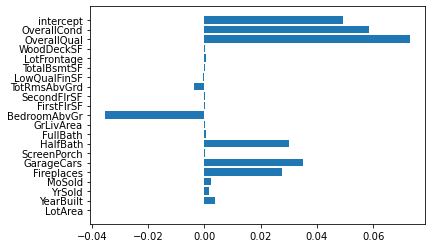

In [4]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=.05, fit_intercept=False, max_iter=1000).fit(Z, y)

plt.barh(var_names + ['intercept'], model.coef_)
plt.show()

## L1 Regularization

In [5]:
var_data = data.copy().drop('SalePrice', axis=1)
var_names = list(var_data.columns)
X = var_data.values
Z = np.concatenate([X, np.ones((len(X), 1))], axis=1)
y = np.log(1 + data['SalePrice'])


#Lasso(alpha=1.0, *, fit_intercept=True, normalize='deprecated', precompute=False, copy_X=True, max_iter=1000, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')

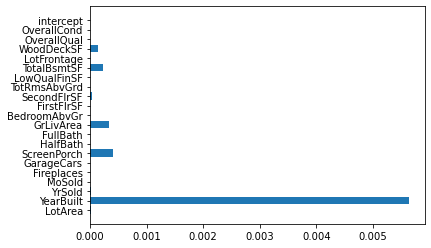

In [6]:
from sklearn.linear_model import Lasso
model = Lasso(alpha=.1, fit_intercept=False, max_iter=1000)
fitted = model.fit(Z, y)

plt.barh(var_names + ['intercept'], fitted.coef_)
plt.show()

# Principal Components Regression

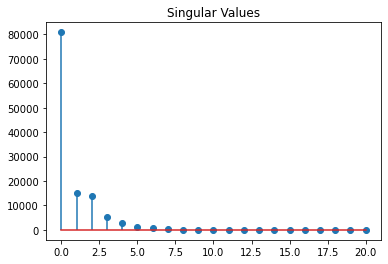

In [10]:
X = var_data.values
Z = np.concatenate([X, np.ones((len(X), 1))], axis=1)


Zmean = np.mean(Z, 0)
Zc = Z - Zmean   # center data
U, S, V = np.linalg.svd(Zc)
plt.stem(S)
plt.title("Singular Values")
plt.show()


The 20 principal components of the data explains 0.9999999999999999 of its variance


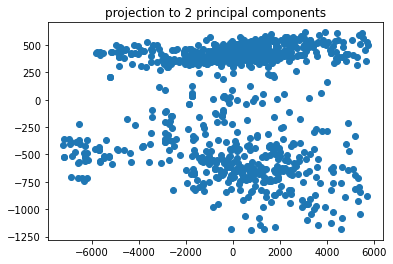

0.8813367852737968

In [11]:
import statsmodels.api as sm

k = 20
Zpc = U[:, :k] @ np.diag(S[:k])
print(f"The {k} principal components of the data explains {np.sum(S[:k]/S.sum())} of its variance")

plt.scatter(Zpc[:,0], Zpc[:,1])
plt.title("projection to 2 principal components")
plt.show()

model = sm.OLS(y, sm.add_constant(Zpc))
results = model.fit()
results.rsquared

## Bias 

It appears that the residuals have an interesting patter when plotted against ``MoSold``, suggesting we might want to consider each month seperately or introduce a dummy variable for each month. 

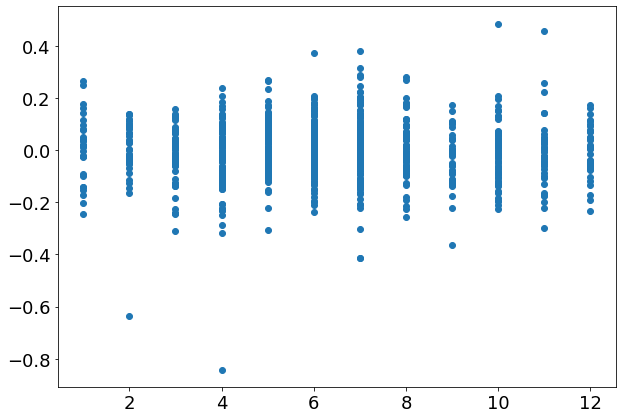

In [422]:
v1 = 'MoSold'
var_data = data.copy().drop(['SalePrice', v1], axis=1)
#var_data['ses_cos'] = np.cos(2*np.pi * data['MoSold'] / 12)
#var_data['ses_sin'] = np.sin(2*np.pi * data['MoSold'] / 12)

var_names = list(var_data.columns)
X = var_data.values
Z = np.concatenate([X, np.ones((len(X), 1))], axis=1)
y = np.log(1 + data['SalePrice'])

model = sm.OLS(y, Z).fit()

plt.scatter(data[v1], results.resid)
plt.show()

In [353]:
Z = np.array([[1, 1, 1, 1, 1],
    [1.1, -2.1, 3.1, 3.4, -0.8]]).T
Z.shape
y = np.array([1, 0, 2, 2, 0])

model = sm.OLS(y, Z).fit()
model.predict(Z.mean(0))

array([1.])

## QQ plots

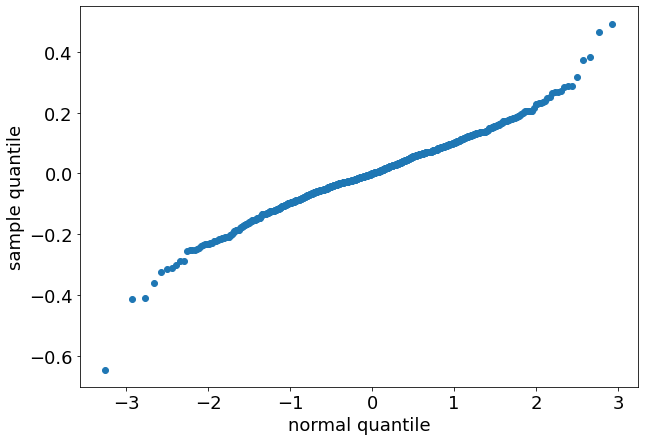

In [423]:
eps_sorted = np.sort(model.resid)
ii = np.arange(len(eps_sorted))
qq = (ii - 1/2) / len(ii)
normal_qq = scipy.stats.norm.ppf(qq)

plt.scatter(normal_qq, eps_sorted)
plt.xlabel('normal quantile')
plt.ylabel('sample quantile')
plt.show()


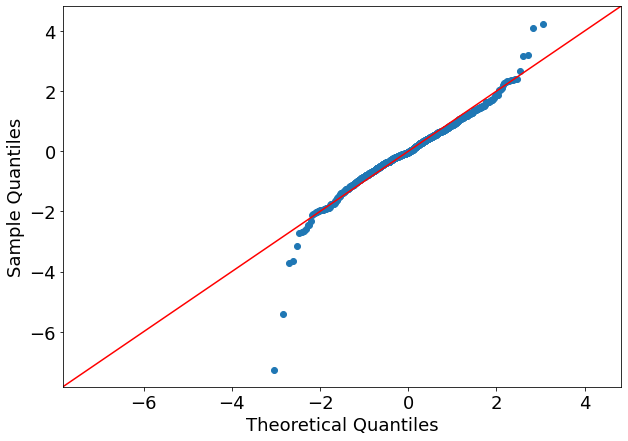

In [184]:
# using designated function and normalization by st error:
sm.qqplot(model.resid / np.sqrt(model.mse_resid) , line ='45')
plt.show()

## Outliers

In [424]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


covariates = ['LotArea', 'YearBuilt', 'GrLivArea', 'BedroomAbvGr',
       'TotRmsAbvGrd', 'TotalBsmtSF', 'OverallQual']
target = 'SalePrice'

model = smf.ols(formula= target + " ~ " + " + ".join(covariates), data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     584.4
Date:                Wed, 01 Jun 2022   Prob (F-statistic):               0.00
Time:                        21:03:55   Log-Likelihood:                -10270.
No. Observations:                 886   AIC:                         2.056e+04
Df Residuals:                     878   BIC:                         2.059e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -9.108e+05   7.55e+04    -12.069      0.000   -1.06e+06   -7.63e+05
LotArea          3.2913      0.362      9.081      0.000       2.580       4.003
YearBuilt      438.6208     39.807     11.019      0.000     360.493     516.749
GrLivArea       60.7708      4.280     14.198      0.000      52.370      69.172
BedroomAbvGr -1.178e+04   1822.909     -6.460      0.000   -1.54e+04   -8198.097
TotRmsAbvGrd   136.8338   1258.347      0.109      0.913   -2332.886    2606.553
TotalBsmtSF     33.1636      2.990     11.092      0.000      27.295      39.032
OverallQual   1.651e+04   1161.394     14.218      0.000    1.42e+04    1.88e+04
==============================================================================
Omnibus:                      105.036   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              576.987
Skew:                           0.373   Prob(JB):                    5.11e-126
Kurtosis:                       6.882   Cond. No.                     8.23e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.23e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

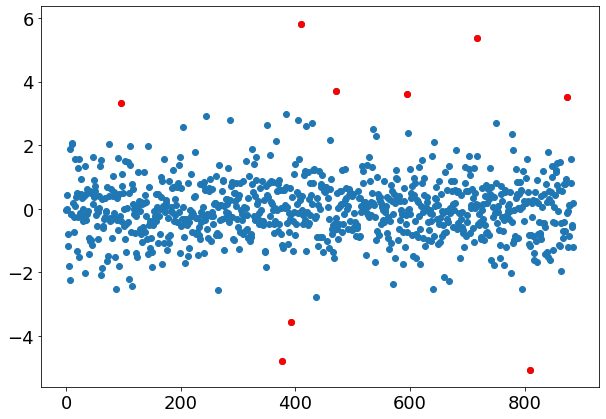

In [425]:
ii = np.arange(len(model.resid))
resid_normalized = model.resid / np.sqrt(model.mse_resid)
plt.scatter(ii, resid_normalized)
suspected_outliers = np.abs(resid_normalized) > 3
plt.scatter(ii[suspected_outliers], resid_normalized[suspected_outliers], color='red')
plt.show()

In [426]:
# Finding outliers using CV:

def cv(resid, Z):
    H = Z @ np.linalg.inv(Z.T @ Z) @ Z.T
    h = np.diag(H)
    return np.sum(resid ** 2 / (1 - h))


data = sm.add_constant(load_house_prices_data())

CVerr = []
for i in range(len(data)):
    d_i = data.iloc[i:i+1]
    data_minus_i = data.drop(d_i.index)
    
    y = data_minus_i['SalePrice']
    data_vars = data_minus_i.drop('SalePrice', axis=1)
    
    model = sm.OLS(y, data_vars).fit()
    
    eps_i = np.mean(d_i['SalePrice'] - model.predict(d_i.drop('SalePrice', axis=1)))
    CVerr += [eps_i / np.sqrt(model.mse_resid)]


Masked a fraction of 0.14971209213051823 of the data due to outliers


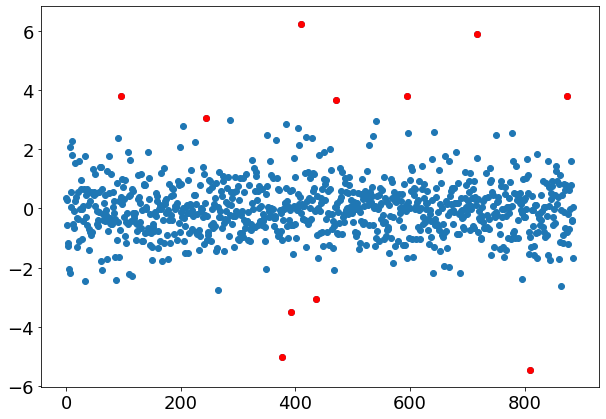

In [427]:
resid_cv = np.array(CVerr)
plt.scatter(ii, resid_cv)
suspected_outliers = np.abs(resid_cv) > 3
plt.scatter(ii[suspected_outliers], resid_cv[suspected_outliers], color='red')
plt.show()

# Heteroscedasticity

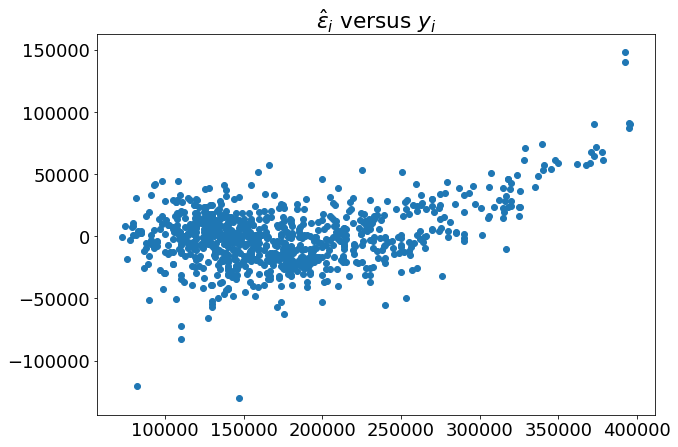

In [405]:
var_data = data.copy().drop(['SalePrice'], axis=1)
#var_data['ses_cos'] = np.cos(2*np.pi * data['MoSold'] / 12)
#var_data['ses_sin'] = np.sin(2*np.pi * data['MoSold'] / 12)

X = var_data.values
Z = np.concatenate([X, np.ones((len(X), 1))], axis=1)
y = data['SalePrice']

model = sm.OLS(y, Z).fit()

plt.scatter(y, model.resid)
plt.title("$\hat{\epsilon}_i$ versus $y_i$")
plt.show()


It appears that the residuals' variance gets larger the larger $y$ we try to predcit (more difficult to predict more expensive houses)

Taking a log transform of $y$ may improve things:

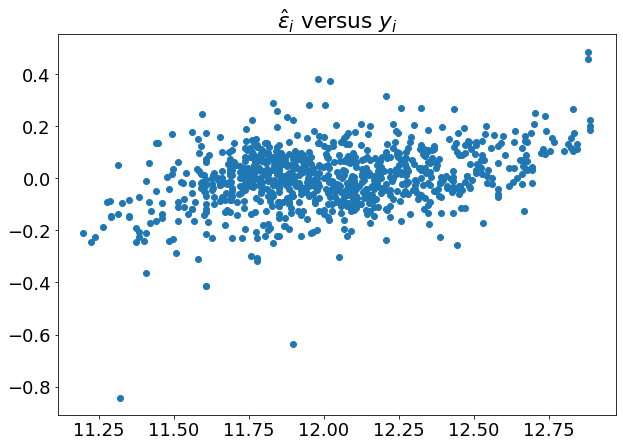

In [408]:
var_data = data.copy().drop(['SalePrice'], axis=1)
#var_data['ses_cos'] = np.cos(2*np.pi * data['MoSold'] / 12)
#var_data['ses_sin'] = np.sin(2*np.pi * data['MoSold'] / 12)

X = var_data.values
Z = np.concatenate([X, np.ones((len(X), 1))], axis=1)
y = np.log(1 + data['SalePrice'])


model = sm.OLS(y, Z).fit()

plt.scatter(y, model.resid)
plt.title("$\hat{\epsilon}_i$ versus $y_i$")
plt.show()


## Correlation in the residulas

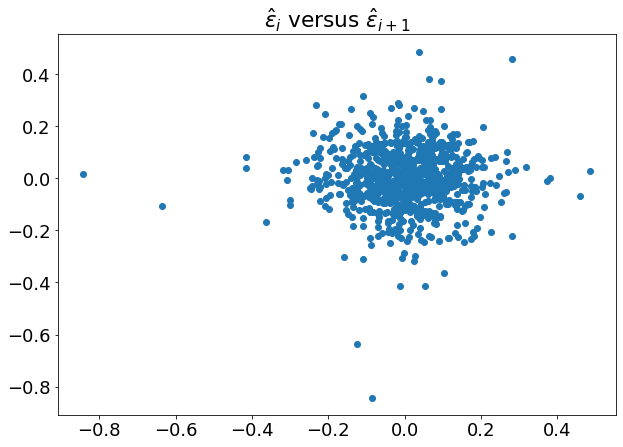

In [409]:
var_data = data.copy().drop(['SalePrice'], axis=1)
#var_data['ses_cos'] = np.cos(2*np.pi * data['MoSold'] / 12)
#var_data['ses_sin'] = np.sin(2*np.pi * data['MoSold'] / 12)

X = var_data.values
Z = np.concatenate([X, np.ones((len(X), 1))], axis=1)
y = np.log(1 + data['SalePrice'])


model = sm.OLS(y, Z).fit()

plt.scatter(model.resid[:-1], model.resid[1:])
plt.title("$\hat{\epsilon}_i$ versus $\hat{\epsilon}_{i+1}$")
plt.show()


Uncorrelatedness assumption seems to be reasonable